UNIVERISTY: Lightwave Research Laboratory, Columbia University

STUDENT: Brett George

MODULE NAME: SWSS Configuration Algorithm

DESCRIPTION: Determines SWSS configuration based on $I/O/\lambda$ tuples of each signal, assigns signals to specific channels, and tunes the physical switch channels to their respective wavelengths

COMMENTS: 
> *find_likeness(sig1, sig2)* determines how the graph of the switch should be connected based on likeness between $I/O/\lambda$ tuples
> 
> *build_graph(sig, names, graph)* takes the signals $I/O/\lambda$ tuples, signal names, and an empty graph and constructs the network for the switch permutation
> 
> *assign_channels(io, sw_colors, lookup_table)* takes the $I/O/\lambda$ tuples, checks the colors, and assigns the channels to tune
> 
> *zero()* asks the user if they want to set all the control voltages to 0V for all channels on the switch
> 
> *set_multiple_res_wl(Channel Numbers, Desired Res wls, model)* sets the resonant wavelength for multiple channels at the same time

In [14]:
import sys
sys.path.insert(1, 'Drivers')

import Qontrol

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import pyvisa

import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display, Markdown, Latex
from IPython.display import clear_output
from ipywidgets import interact, interactive, fixed, interact_manual

# Step 1: Determine the Switch Configuration

In [3]:
def find_likeness(sig1, sig2):
    for i in range(0, 3):
        if (sig1[i] == sig2[i]):
            return True
    return False

def build_graph(sig, names, graph):
    edge_list = list()
    for i in range(0, len(names)):
        for j in range (0, len(names)):
            if j != i:
                # Check likeness with the other signals
                if (find_likeness(sig[i], sig[j])):
                    edge_list.append((names[i], names[j]))
    graph.add_edges_from(edge_list)
    return graph

In [4]:
# Test Setup
sig_names = ['S1', 'S2', 'S3', 'S4',
             'S5', 'S6', 'S7', 'S8',
             'S9', 'S10', 'S11', 'S12',
             'S13', 'S14', 'S15', 'S16']
# signals = [(1, 1, 1), (1, 2, 2), (1, 4, 3), (1, 3, 4), 
#            (2, 4, 1), (2, 1, 2), (2, 1, 3), (2, x, 4),
#            (3, x, 1), (3, x, 2), (3, 2, 3), (3, 2, 4),
#            (4, 3, 1), (4, x, 2), (4, 3, 3), (4, x, 4)]

signals = [(1, 1, 1), (1, 2, 2), (1, 4, 3), (1, 3, 4), 
           (2, 4, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4),
           (3, 2, 1), (3, 3, 2), (3, 2, 3), (3, 2, 4),
           (4, 3, 1), (4, 4, 2), (4, 3, 3), (4, 4, 4)]

# signals = [(1, 1, 1), (1, 1, 2), (1, 4, 3), (1, 2, 4), 
#            (2, 2, 1), (2, 2, 2), (2, 1, 3), (2, 3, 4),
#            (3, 3, 1), (3, 4, 2), (3, 3, 3), (3, 1, 4),
#            (4, 4, 1), (4, 3, 2), (4, 2, 3), (4, 4, 4)]
sig_io = dict(zip(sig_names, signals))
sig_dict =  dict.fromkeys(sig_names)

In [5]:
# Input 1 Signal 1 Possibilities:
possible_combos = [(1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4),
                   (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4),
                   (1, 3, 1), (1, 3, 2), (1, 3, 3), (1, 3, 4),
                   (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4)]

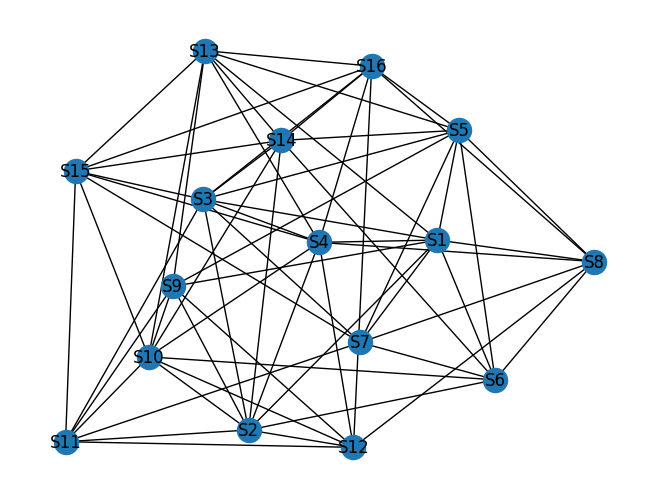

In [6]:
## Permutation (Richard's Paper)
sig_dict =  dict.fromkeys(sig_names)
GX = nx.Graph()
GX = build_graph(signals, sig_names, GX)
colors = nx.coloring.greedy_color(GX, strategy='DSATUR')

nx.draw_spring(GX, with_labels=True)
plt.show()

In [8]:
colors

{'S1': 0,
 'S2': 1,
 'S3': 2,
 'S4': 3,
 'S5': 1,
 'S13': 2,
 'S10': 0,
 'S14': 3,
 'S15': 1,
 'S16': 0,
 'S6': 2,
 'S8': 4,
 'S7': 3,
 'S11': 4,
 'S9': 3,
 'S12': 2}

# Step 2: Build Channel Lookup Table

In [10]:
## Search is based on the column number that has been assigned. The second argument after every channel pair is if it is being used.
## Input  : (outer, inner)
## Output : (inner, outer)
channel_lookup = {
    'inputs':  {0: {(80, 81): 0, (88, 87): 0, (2, 1): 0, (11, 10): 0},
                1: {(74, 76): 0, (79, 78): 0, (4, 3): 0, (20, 16): 0},
                2: {(69, 70): 0, (67, 72): 0, (8, 7): 0, (25, 22): 0},
                3: {(64, 65): 0, (58, 63): 0, (41, 42): 0, (31, 32): 0},
                4: {(59, 60): 0, (53, 54): 0, (43, 44): 0, (37, 38): 0} 
               },
    'outputs': {0: {(83, 82): 0, (92, 91): 0, (6, 5): 0, (12, 13): 0},
                1: {(77, 73): 0, (90, 89): 0, (15, 14): 0, (17, 19): 0},
                2: {(71, 68): 0, (86, 85): 0, (21, 26): 0, (23, 24): 0},
                3: {(61, 62): 0, (51, 52): 0, (30, 35): 0, (28, 29): 0},
                4: {(55, 56): 0, (49, 50): 0, (39, 40): 0, (33, 34): 0} 
               }
    }
col_sig1 = colors['S1']
in_sig1 = signals[0][0]
out_sig1 = signals[0][1]
print('Signal 1: Input ' + str(in_sig1) + ' to Output ' + str(out_sig1) + ' via column ' + str(col_sig1))

Signal 1: Input 1 to Output 1 via column 0


In [11]:
i = 0
for name in sig_names:
    col_sig = colors[name]
    in_sig = signals[i][0]
    out_sig = signals[i][1]
    i += 1
    print('Signal ' + str(i) + ': Input ' + str(in_sig) + ' to Output ' + str(out_sig) + ' via column ' + str(col_sig))

Signal 1: Input 1 to Output 1 via column 0
Signal 2: Input 1 to Output 2 via column 1
Signal 3: Input 1 to Output 4 via column 2
Signal 4: Input 1 to Output 3 via column 3
Signal 5: Input 2 to Output 4 via column 1
Signal 6: Input 2 to Output 1 via column 2
Signal 7: Input 2 to Output 1 via column 3
Signal 8: Input 2 to Output 1 via column 4
Signal 9: Input 3 to Output 2 via column 3
Signal 10: Input 3 to Output 3 via column 0
Signal 11: Input 3 to Output 2 via column 4
Signal 12: Input 3 to Output 2 via column 2
Signal 13: Input 4 to Output 3 via column 2
Signal 14: Input 4 to Output 4 via column 3
Signal 15: Input 4 to Output 3 via column 1
Signal 16: Input 4 to Output 4 via column 0


**Testing Functionality:**

In [12]:
## Find the possible inputs and outputs and then check if its valid. 
## If so, then mark these are tuned and go to the next signal. 
## If not, go back and look for another I/O pair
print('Possible Input Channels: ' + str(list(channel_lookup['inputs'][col_sig1])[in_sig1-1]))
print('Possible Output Channels: ' + str(list(channel_lookup['outputs'][col_sig1])[out_sig1-1]))

Possible Input Channels: (80, 81)
Possible Output Channels: (83, 82)


# Step 3: Assign switch channels to signals

In [13]:
def assign_channels(io, sw_colors, lookup_table):
    i = 0
    channel_assignments = dict()
    for key in sw_colors:
        col = sw_colors[key]
        in_sig = io[key][0]
        out_sig = io[key][1]
        
        input_list = lookup_table['inputs'][col]
        output_list = lookup_table['outputs'][col]
        
        inputs = list(input_list)[in_sig-1]
        input_list[inputs] = 1
        lookup_table['inputs'][col] = input_list
        
        outputs = list(output_list)[out_sig-1]
        output_list[outputs] = 1
        lookup_table['outputs'][col] = output_list

        wl = io[key][2]
        channel_assignments[key] = [inputs, outputs, wl]
        i += 1
        
    return channel_assignments, lookup_table

In [14]:
channels, channel_lookup = assign_channels(sig_io, colors, channel_lookup)
channels

{'S1': [(80, 81), (83, 82), 1],
 'S2': [(74, 76), (90, 89), 2],
 'S3': [(69, 70), (23, 24), 3],
 'S4': [(64, 65), (30, 35), 4],
 'S5': [(79, 78), (17, 19), 1],
 'S13': [(25, 22), (21, 26), 1],
 'S10': [(2, 1), (6, 5), 2],
 'S14': [(31, 32), (28, 29), 2],
 'S15': [(20, 16), (15, 14), 3],
 'S16': [(11, 10), (12, 13), 4],
 'S6': [(67, 72), (71, 68), 2],
 'S8': [(53, 54), (55, 56), 4],
 'S7': [(58, 63), (61, 62), 3],
 'S11': [(43, 44), (49, 50), 3],
 'S9': [(41, 42), (51, 52), 1],
 'S12': [(8, 7), (86, 85), 4]}

In [15]:
channel_lookup

{'inputs': {0: {(80, 81): 1, (88, 87): 0, (2, 1): 1, (11, 10): 1},
  1: {(74, 76): 1, (79, 78): 1, (4, 3): 0, (20, 16): 1},
  2: {(69, 70): 1, (67, 72): 1, (8, 7): 1, (25, 22): 1},
  3: {(64, 65): 1, (58, 63): 1, (41, 42): 1, (31, 32): 1},
  4: {(59, 60): 0, (53, 54): 1, (43, 44): 1, (37, 38): 0}},
 'outputs': {0: {(83, 82): 1, (92, 91): 0, (6, 5): 1, (12, 13): 1},
  1: {(77, 73): 0, (90, 89): 1, (15, 14): 1, (17, 19): 1},
  2: {(71, 68): 1, (86, 85): 1, (21, 26): 1, (23, 24): 1},
  3: {(61, 62): 1, (51, 52): 1, (30, 35): 1, (28, 29): 1},
  4: {(55, 56): 1, (49, 50): 1, (39, 40): 0, (33, 34): 0}}}

# Step 4: Convert Wavelength Number to Wavelength Value

In [16]:
wavelengths = [1541, 1543, 1545, 1547]
for key in channels:
    channels[key][2] = wavelengths[channels[key][2]-1]

In [17]:
channels

{'S1': [(80, 81), (83, 82), 1541],
 'S2': [(74, 76), (90, 89), 1543],
 'S3': [(69, 70), (23, 24), 1545],
 'S4': [(64, 65), (30, 35), 1547],
 'S5': [(79, 78), (17, 19), 1541],
 'S13': [(25, 22), (21, 26), 1541],
 'S10': [(2, 1), (6, 5), 1543],
 'S14': [(31, 32), (28, 29), 1543],
 'S15': [(20, 16), (15, 14), 1545],
 'S16': [(11, 10), (12, 13), 1547],
 'S6': [(67, 72), (71, 68), 1543],
 'S8': [(53, 54), (55, 56), 1547],
 'S7': [(58, 63), (61, 62), 1545],
 'S11': [(43, 44), (49, 50), 1545],
 'S9': [(41, 42), (51, 52), 1541],
 'S12': [(8, 7), (86, 85), 1547]}

**Pass this to the Tuning Voltage Function to configure the switch**

# Step 5: Tune the Switch

In [2]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('ASRL6::INSTR',
 'GPIB0::4::INSTR',
 'GPIB1::2::INSTR',
 'USB0::0x1313::0x8075::P5003074::0::INSTR')

In [4]:
bosa = rm.open_resource('GPIB0::4::INSTR')
bosa.query('*IDN?\n')

'ARAGON-PHOTONICS,BOSA,400C,BOSA_UI_3.5.114'

In [4]:
###### Initialize qontrol module
serial_port_name = "COM5" # Qontrol must be connected to COM3 if using Windows. Otherwise modify this line.
QC = Qontrol.QXOutput(serial_port_name = serial_port_name, response_timeout = 0.5)
print ("Qontroller '{:}' initialised with firmware {:} and {:} channels".format(QC.device_id, QC.firmware, QC.n_chs) )

Qontroller 'Q8iv-037E' initialised with firmware v2.4.1 and 96 channels


In [5]:
###### Initialization of variables
global voltage

global current

voltage = np.zeros(QC.n_chs)
current = np.zeros(QC.n_chs)

In [6]:
####### Zero out current and voltage, Adapted from Richard Dai & Kaylx Jang
def zero():
    print("\n\nWARNING!!! \n\nThis will set the voltage and current on ALL channels to ZERO\n\n")
    print("Would you like to proceed? (y/n)\n")

    value_in = input()

    if (value_in.upper() == "Y"):
        QC.v[:] = 0
        voltage = np.zeros(QC.n_chs)
        current = np.zeros(QC.n_chs)
        print("\nZeroing Complete")
        
    else:
        print("No changes were made")

In [7]:
###### Apply voltage or current to specified channel
def qontrol_interface(channel1, channel2, type = 'v', entry1 = 0, entry2 = 0):

    if (type == 'v'):
        QC.v[channel1] = entry1
        voltage[channel1] = entry1
        QC.v[channel2] = entry2
        voltage[channel2] = entry2

        table = f"""
| Channel | Set Voltage | Measured Voltage | Measured Current |
|---------|-------------|------------------|------------------|
| {channel1} | {entry1:.2f} | {QC.v[channel1]:.3f} | {QC.i[channel1]:.3f} |
| {channel2} | {entry2:.2f} | {QC.v[channel2]:.3f} | {QC.i[channel2]:.3f} |
"""
        measurement = Markdown(table)
        
    elif (type == 'i'):
        QC.i[channel1] = entry1
        current[channel1] = entry1
        QC.i[channel2] = entry2
        current[channel2] = entry2

        table = f"""
| Channel | Set Current | Measured Voltage | Measured Current |
|---------|-------------|------------------|------------------|
| {channel1} | {entry1:.2f} | {QC.v[channel1]:.3f} | {QC.i[channel1]:.3f} |
| {channel2} | {entry2:.2f} | {QC.v[channel2]:.3f} | {QC.i[channel2]:.3f} |
"""
        measurement = Markdown(table)
        
    return measurement

###### Slider API
def qontrol_sliders(channel1, channel2, vmin = 0, vmax = 5, vstep = 0.1, type = 'v'):

    if (type == 'v'):
        interact(qontrol_interface, channel1 = fixed(channel1), channel2 = fixed(channel2), type = fixed(type), 
                 entry1 = widgets.FloatSlider(min = vmin, max = vmax, step = vstep, value = voltage[channel1]), 
                 entry2 = widgets.FloatSlider(min = vmin, max = vmax, step = vstep, value = voltage[channel2])) 
    elif (type == 'i'):
        interact(qontrol_interface, channel1 = fixed(channel1), channel2 = fixed(channel2), type = fixed(type), 
                 entry1 = widgets.FloatSlider(min = vmin, max = vmax, step = vstep, value = current[channel1]), 
                 entry2 = widgets.FloatSlider(min = vmin, max = vmax, step = vstep, value = current[channel2])) 
    else: 
        Markdown('# Error in Type\n')

In [8]:
##### Zeros all channels
zero()



WARNING!!! 

This will set the voltage and current on ALL channels to ZERO


Would you like to proceed? (y/n)



 y



Zeroing Complete


**Make sure to change path of config file below**

In [18]:
q_vals = pd.read_csv('q_vals_willow_full.csv', index_col=False)

In [19]:
q_vals

,gen1,Ch80,Ch74,Ch69,Ch64,Ch59,Ch82,Ch73,Ch68,Ch62,...,Ch25,Ch31,Ch37,Ch13,Ch19,Ch24,Ch29,Ch34,gen,gen.1
0,1.640631,1.618643,1.606020,1.647507,1.667986,1.629315,1.622842,1.658867,1.640978,1.673368,...,1.567952,1.667395,1.571154,1.611373,1.623951,1.607572,1.622246,1.626944,1.636925,1.636925
1,7.587052,7.703809,7.410444,7.655094,7.501887,7.779737,7.477449,7.481282,7.702919,7.514179,...,7.120592,7.577885,7.068106,7.330918,7.796832,7.800099,7.798254,7.617346,7.514183,7.514183
2,1525.639300,1525.797448,1525.792203,1525.565163,1526.386666,1525.788764,1525.601360,1525.023802,1525.619935,1525.410213,...,1526.057179,1525.715631,1525.717556,1525.301549,1525.181170,1525.461279,1525.671092,1525.147567,1525.528154,1525.528154


In [20]:
## Function called in tuning voltage calculation
def solve_for_y(poly_coeffs, y):
    pc = poly_coeffs.copy()
    pc[-1] -= y
    roots = np.roots(pc)
    val = 0
    for i in range(0, len(roots)):
        if (roots[i] >= 0.5) and (roots[i] <= 3.3):
            val = roots[i]
    return val

In [21]:
## Multiple Channel Tuning
def set_multiple_res_wl(channels, wl, model):
    print('Calculating tuning voltage based on the ' + model + ' channel model')
    print('\n')
    for i in range(0, len(channels)):
        if model == 'general':
            if (wl[i] > 1528.5) and (wl[i] < 1553.5):
                v_set = float(round(solve_for_y(list(q_vals['gen']), wl[i]), 4))
                print('Tuning Ch. ' + str(channels[i]) + ' to ' + str(v_set) + ' V')
                if v_set > 0.0 and v_set <= 3.3:
                    QC.v[channels[i]] = v_set
                    v_meas = QC.v[channels[i]]
                    time.sleep(1)
                    print('\n')
            else:
                print('Invalid wavelength entered')
        elif model == 'single':
            if (wl[i] > 1528.5) and (wl[i] < 1553.5):
                v_set = float(round(solve_for_y(list(q_vals['Ch' + str(channels[i])]), wl[i]), 4))
                print('Tuning Ch. ' + str(channels[i]) + ' to ' + str(v_set) + ' V')
                if v_set > 0.0 and v_set <= 3.3:
                    QC.v[channels[i]] = v_set
                    v_meas = QC.v[channels[i]]
                    time.sleep(1)
                    print('\n')
            else:
                print('Invalid wavelength entered')
        else:
            print('Invalid model')
    return

**Start Tuning**

In [14]:
zero()



WARNING!!! 

This will set the voltage and current on ALL channels to ZERO


Would you like to proceed? (y/n)



 y



Zeroing Complete


**Single Route Manual Tuning**

In [11]:
qontrol_sliders(channel1 = 80, channel2 = 81, vmin = 0, vmax = 2, vstep = 0.01, type = 'v')

interactive(children=(FloatSlider(value=0.0, description='entry1', max=2.0, step=0.01), FloatSlider(value=0.0,…

In [ ]:
qontrol_sliders(channel1 = 92, channel2 = 91, vmin = 0, vmax = 2, vstep = 0.01, type = 'v')

**Automated Tuning**

In [ ]:
chans_outer = [80, 74, 69, 64, 59]
desired_wls = [1533, 1536, 1539, 1542, 1545]
set_multiple_res_wl(chans_outer, desired_wls, 'single')

In [ ]:
chans_inner = [81, 92, 76, 90, 70, 86]
desired_wls = [1536, 1536, 1539, 1539, 1542, 1542]
set_multiple_res_wl(chans_inner, desired_wls, 'general')

**Close Qontrol Connection**

In [12]:
QC.close()

**BOSA Spectrum**

In [ ]:
from scipy.signal import argrelextrema

data = bosa.query('TRACe?')
tuned_data_split = [float(i) for i in data.split(',')]
wl_data = tuned_data_split[::2]
db_data = tuned_data_split[1::2]

## package up i/v data

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
                  # '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78']

plt.plot(wl_data, db_data)

plt.ylim(-57, 0)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.title('Tuning Multiple Channels between Ports 1 & 2')
plt.xlabel("Wavelength [nm]")
plt.ylabel("Transmission [dB]")

plt.gcf().set_size_inches(10, 6)

plt.savefig('WillowFourWLs.png', bbox_inches='tight')

plt.show()

**Example of Tuning Everything**

In [ ]:
## Break up channels numbers and wavelength by outer and inner rings - each has different models
chans_outer = []
chans_inner = []
desired_wls = []
for keys in channels:
    chans_outer.append(channels[keys][0][0])
    chans_inner.append(channels[keys][0][1])
    chans_inner.append(channels[keys][1][0])
    chans_outer.append(channels[keys][1][1])
    desired_wls += 2 * [channels[keys][2]]

In [ ]:
## Tune all the rings on the switch
set_multiple_res_wl(chans_outer, desired_wls, 'single')
set_multiple_res_wl(chans_inner, desired_wls, 'general')

**Create a readout of all channels**

In [ ]:
for key in channel_lookup['inputs']:
    test = []
    for i in range(0, 5):
        for j in range(0, 4):
            test.append(QC.i[list(channel_lookup['inputs'][i])[j][0]])
            # print(QC.i[list(channel_lookup['inputs'][i])[j][0]])
            test.append(QC.i[list(channel_lookup['inputs'][i])[j][1]])
            # print(QC.i[list(channel_lookup['inputs'][i])[j][1]])
for key in channel_lookup['outputs']:
    for i in range(0, 5):
        for j in range(0, 4):
            test.append(QC.i[list(channel_lookup['outputs'][i])[j][0]])
            # print(QC.i[list(channel_lookup['outputs'][i])[j][0]])
            test.append(QC.i[list(channel_lookup['outputs'][i])[j][1]])
            # print(QC.i[list(channel_lookup['outputs'][i])[j][1]])
# print(test)

## Test if any currents read higher than 0.01 mA
value = 0.001
if any(i > value for i in test):
    print("There are elements greater than", value)
else:
    print("No elements are greater than", value)

In [ ]:
print(test)